In [63]:
import datetime 
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import numpy as np
import math

def download_prices_stooq(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Download daily OHLCV from Stooq using pandas_datareader.
    For US stocks, Stooq often uses the format 'AAPL.US'.
    """

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    candidates = [
        ticker,
        ticker.upper(),
        f"{ticker.upper()}.US",
        f"{ticker.upper()}.FR"
    ]

    last_err = None
    for t in candidates:
        try:
            df = pdr.DataReader(t, "stooq", start, end)
            if df is not None and not df.empty:
                # Stooq returns newest->oldest; sort to oldest->newest
                df = df.sort_index()
                df.index = pd.to_datetime(df.index)
                return df
        except Exception as e:
            last_err = e

    raise RuntimeError(
        f"Failed to download data for {ticker} from Stooq. "
        f"Tried: {candidates}. Last error: {last_err}"
    )

# ------------------------------------------
# Parameters
# ------------------------------------------
ticker = "MSFT"
start_date = "2010-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")

# ------------------------------------------
# Download data (Stooq)
# ------------------------------------------
data = download_prices_stooq(ticker, start_date, end_date)

# Use Close (Stooq doesn't always provide Adj Close)
stock = data["Close"].astype(float)

<function matplotlib.pyplot.show(close=None, block=None)>

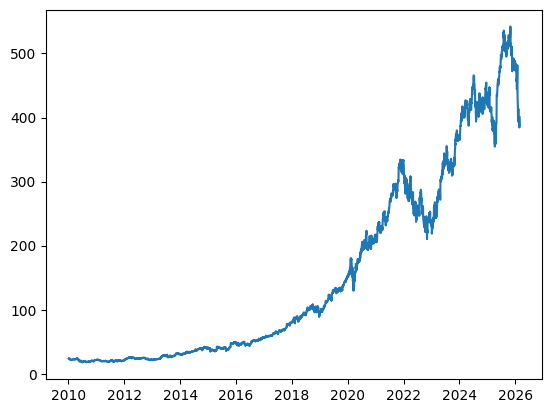

In [64]:
plt.plot(stock)
plt.show

In [65]:
WORK_DAYS_PER_YEAR = 252 
dt = 1 / WORK_DAYS_PER_YEAR # (tk+1 - tk) in years
N = len(data) - 1 # Number of returns (N-1 because we lose one day when we shift)
data["Close_tmr"] = data["Close"].shift(-1)#Shift to get tomorrow's close price
Return = ((data["Close_tmr"] - data["Close"]) / data["Close"]).dropna()#we calculate the return in another column

def mean_est_Calc(Return, work_days, N):
    mean_est=work_days/(N)*Return.sum()#sum all the returns
    return mean_est

mean_val_est = mean_est_Calc(Return, WORK_DAYS_PER_YEAR, N)
print("The estimated mean anual return is: ",mean_val_est*100,"%")




The estimated mean anual return is:  20.82106146144602 %


In [66]:
def vol_est_Calc(Return, dt, mean_est, work_days, N):
    daily_var = (Return - dt * mean_est)**2 # we create a column with daily variance
    var_estimator = (work_days / (N - 1)) * (daily_var.sum()) # sum the daily var to get the estimator
    return var_estimator

var_val_est = vol_est_Calc(Return, dt, mean_val_est, WORK_DAYS_PER_YEAR, N)

print(var_val_est)
print("The estimated variance is: ",var_val_est*100,"%")
print("The estimated volatility is: ",np.sqrt(var_val_est)*100,"%")

def vol_est_Calc(Return, dt, mean_est, work_days, N):
    daily_var=(Return-dt*mean_est)**2 #we create a column with daily variance
    var_estimator=(work_days/(N-1))*(daily_var.sum()) #sum the daily var to get the estimator
    
    return var_estimator

0.06574758082705978
The estimated variance is:  6.574758082705978 %
The estimated volatility is:  25.641291080415545 %


In [67]:
data["lnH_L^2"]=(np.log(data["High"]/data["Low"]))**2

def vol_park_Calc(data, work_days, N):
    Vol_Park=np.sqrt((work_days/(N+1))*(1/(4*np.log(2)))*(data["lnH_L^2"].sum()))#We calculate the Parkinson estimator
    return Vol_Park

Vol_park=vol_park_Calc(data, WORK_DAYS_PER_YEAR, N)
print("The parkinson estimator for the volatility is: ",Vol_park*100,"%")



The parkinson estimator for the volatility is:  20.337011875716886 %


There is a notable diference between the two estimators
$$\text{Relative Gap} = \frac{\hat{\sigma}_{\text{Classical}} - \hat{\sigma}_{\text{Parkinson}}}{\hat{\sigma}_{\text{Classical}}} \times 100=20.95\%$$
It is probably because parkinson estimator also takes the daily volatility in account (the highs and lows) when the classical one is only focused on the closing price. Parkinson's seems therefore more acurate (Furthermore, the work_day variable may not be 100% true for every year). 

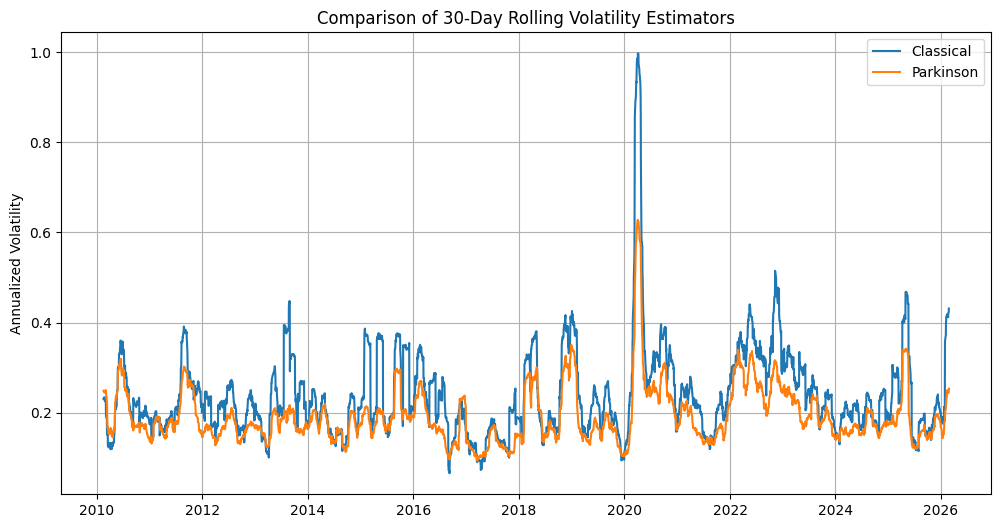

In [68]:
window=30 #in days 
daily_var = (Return - dt * mean_val_est)**2
#For the classical estimator
data["vol_est_row"]=np.sqrt((WORK_DAYS_PER_YEAR/(window-1))*(daily_var.rolling(window).sum()))#we create a column with estimators for every 30 days

#For Parkinson's estimator
data["vol_P_est_row"]=np.sqrt(((WORK_DAYS_PER_YEAR/(window)))*(1/(4*np.log(2)))*(data["lnH_L^2"].rolling(window).sum()))#We calculate the Parkinson estimator

plt.figure(figsize=(12, 6)) 
plt.plot(data["vol_est_row"], label="Classical")
plt.plot(data["vol_P_est_row"], label="Parkinson")
plt.title("Comparison of 30-Day Rolling Volatility Estimators")
plt.ylabel("Annualized Volatility")
plt.legend() 
plt.grid(True) 
plt.show()

As previously noted, the Parkinson estimator provides more information because it incorporates the daily highs and lows rather than just closing prices. This smooths the curve and yields more accurate volatility predictions.

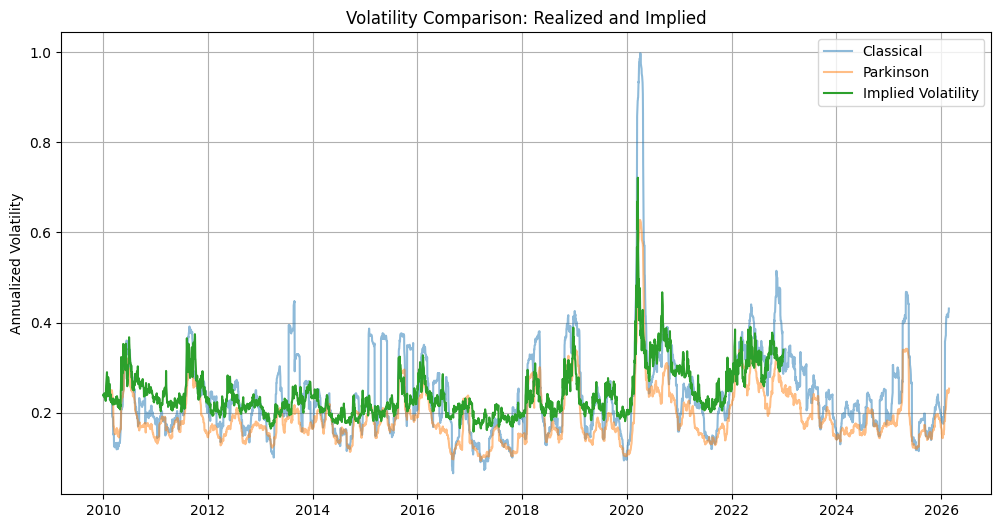

In [69]:
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
from skfolio.preprocessing import prices_to_returns


implied_vol = load_sp500_implied_vol_dataset()
implied_vol = implied_vol.loc["2010":]
plt.figure(figsize=(12, 6)) 
plt.plot(data["vol_est_row"], label="Classical",alpha=0.5)
plt.plot(data["vol_P_est_row"], label="Parkinson",alpha=0.5)
plt.plot(implied_vol["MSFT"], label="Implied Volatility")
plt.title("Volatility Comparison: Realized and Implied")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True)
plt.show()

It seems that the implied volatility often fall between the two realized probabilities. However it seems to follow more the green one especially in very volatile times.

In [70]:
def fetch_spx_close(start_date, end_date):
    """
    Fetch an SPX-like daily close series.
    Primary: FRED SP500
    Fallback: Stooq ^SPX
    Returns a DataFrame with a 'Close' column and DatetimeIndex.
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Try FRED first
    try:
        df = pdr.DataReader("SP500", "fred", start, end)
        df = df.rename(columns={"SP500": "Close"}).dropna()
        df.index = pd.to_datetime(df.index)
        return df
    except Exception:
        pass
        
    # Fallback: Stooq
    df = pdr.DataReader("^SPX", "stooq", start, end)
    df = df.sort_index()
    df.index = pd.to_datetime(df.index)
    return df[["Close"]].dropna()

def fetch_vix_close(start_date, end_date):
    """
    Fetch daily VIX close series.
    Primary: FRED VIXCLS
    Fallback: Stooq VI.F (VIX)
    Returns a DataFrame with a 'Close' column and DatetimeIndex.
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Try FRED first
    try:
        df = pdr.DataReader("VIXCLS", "fred", start, end)
        df = df.rename(columns={"VIXCLS": "Close"}).dropna()
        df.index = pd.to_datetime(df.index)
        return df
    except Exception:
        pass
        
    # Fallback: Stooq (try common symbols)
    for sym in ["VI.F", "vi.f", "VIX", "^vix"]:
        try:
            df = pdr.DataReader(sym, "stooq", start, end)
            df = df.sort_index()
            df.index = pd.to_datetime(df.index)
            if "Close" in df.columns and not df.empty:
                return df[["Close"]].dropna()
        except Exception:
            continue
            
    raise ValueError("No VIX data found from FRED or Stooq.")


spx_symbol = "^SPX"
today = pd.to_datetime("2025-03-05")  
end_date = today
start_date = end_date - datetime.timedelta(days=365)


spx_data = fetch_spx_close(start_date, end_date)
if spx_data.empty:
    raise ValueError("No SPX data found from FRED/Stooq for this window.")

lastBusDay = spx_data.index[-1]
S0 = float(spx_data["Close"].iloc[-1]) # Prix spot de clôture


vix_data = fetch_vix_close(lastBusDay, lastBusDay + datetime.timedelta(days=30))
if vix_data.empty:
    raise ValueError("No VIX data found from FRED/Stooq for this window.")

vix_market = float(vix_data["Close"].iloc[0])


T = 30/365.0
r = 0.02
F0 = S0 * math.exp(r * T) 


print("Last Bus Day:", lastBusDay)
print("S0:", S0)
print("VIX market close:", vix_market)
print("F0:", F0)

Last Bus Day: 2025-03-05 00:00:00
S0: 5842.63
VIX market close: 21.93
F0: 5852.242221579255


In [71]:
import pandas as pd
from yahooquery import Ticker

spx_ticker = Ticker("^SPX")

# Option chain table (may be empty depending on data availability)
oc = spx_ticker.option_chain

if oc is None or (isinstance(oc, pd.DataFrame) and oc.empty):
    print("No option chain returned. If needed, use the CSVs provided on Canvas.")
else:
    # Available expirations are contained in the MultiIndex level "expiration"
    expirations = oc.index.get_level_values("expiration").unique()
    expirations = sorted(pd.to_datetime(expirations).strftime("%Y-%m-%d").tolist())
    print("Available expirations:", expirations)
    # Suppose the next expiration is "2025-04-03" expiry_date = "2025-04-03"  # Fixed to
    # approximate a 30-day horizon as per CBOE



Available expirations: ['2026-02-26', '2026-02-27', '2026-03-02', '2026-03-03', '2026-03-04', '2026-03-05', '2026-03-06', '2026-03-09', '2026-03-10', '2026-03-11', '2026-03-12', '2026-03-13', '2026-03-16', '2026-03-17', '2026-03-18', '2026-03-19', '2026-03-20', '2026-03-23', '2026-03-24', '2026-03-25', '2026-03-26', '2026-03-27', '2026-03-30', '2026-03-31', '2026-04-10', '2026-04-17', '2026-04-24', '2026-04-30', '2026-05-15', '2026-05-29', '2026-06-18', '2026-06-30', '2026-07-17', '2026-07-31', '2026-08-21', '2026-09-18', '2026-09-30', '2026-10-16', '2026-11-20', '2026-12-18', '2026-12-31', '2027-01-15', '2027-02-19', '2027-03-19', '2027-06-17', '2027-12-17', '2028-12-15', '2029-12-21', '2030-12-20', '2031-12-19']


In [72]:
put=pd.read_csv("Put_option_data_2025-04-03_final.csv")
put_sorted=put[(put["strike"])<=F0].sort_values("strike")
put_sorted["strike_tomorrow"]=put_sorted["strike"].shift(-1).fillna(F0)
put_sorted["disretization"]=((put_sorted["bid"]+put_sorted["ask"])/2)*((1/put_sorted["strike"])-(1/put_sorted["strike_tomorrow"]))
put_sorted_discrete=put_sorted["disretization"].sum()

call=pd.read_csv("Call_option_data_2025-04-03_final.csv")
call_sorted=call[F0<=call["strike"]].sort_values("strike")
call_sorted["strike_yesterday"]=call_sorted["strike"].shift(1).fillna(F0)
call_sorted["disretization"]=((call_sorted["bid"]+call_sorted["ask"])/2)*((1/call_sorted["strike_yesterday"])-(1/call_sorted["strike"]))
call_sorted_discrete=call_sorted["disretization"].sum()

def vix_est_Calc(put_discrete, call_discrete, r, T):
    Vix_est = np.sqrt((((2 * np.exp(r * T)) / T) * (put_discrete + call_discrete)))
    return Vix_est

Vix_est=vix_est_Calc(put_sorted_discrete, call_sorted_discrete, r, T)

print("Vix_indicator is esqual to :",Vix_est*100,"%")
print("The CBOE-quoted VIX is :",vix_market,"%")

Vix_indicator is esqual to : 24.40179134006505 %
The CBOE-quoted VIX is : 21.93 %


The estimated VIX of 24.40% is consistent with the CBOE-quoted VIX of 21.93%, validating our model; the observed difference is likely due to our use of a single expiration date and a simplified Forward price F0 that ignores dividends and suppose r=0.02.
Attention single expiratoin date

In [73]:
spx_symbol = "^SPX"
today = pd.to_datetime("2025-03-05")
end_date = today
start_date = end_date - datetime.timedelta(days=365)

spx_data = fetch_spx_close(start_date, end_date)

vix_data = fetch_vix_close(start_date, end_date)

print(spx_data.columns)


print(vix_data.columns)
print(len(spx_data))
print(len(vix_data))

Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
251
259


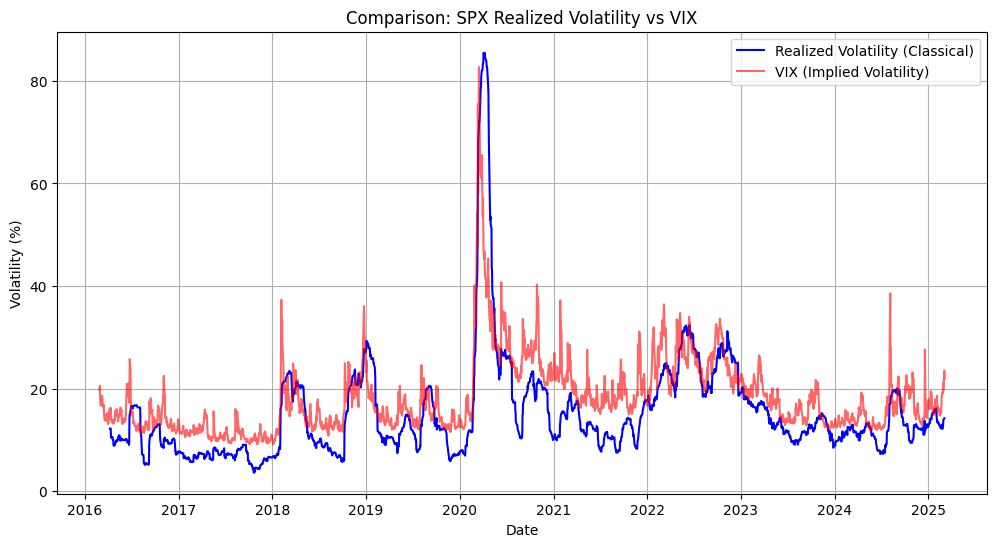

In [ ]:

start_date=pd.to_datetime("2010-01-01")
spx_data = fetch_spx_close(start_date, end_date)
vix_data = fetch_vix_close(start_date, end_date)

spx_data.columns = ["SPX"]
vix_data.columns = ["VIX"]

df_spx_clean = pd.concat([spx_data, vix_data], axis=1).dropna()

WORK_DAYS_PER_YEAR = 252 
dt = 1 / WORK_DAYS_PER_YEAR 
window = 30
N_spx = len(df_spx_clean) - 1

df_spx_clean["SPX_tmr"] = df_spx_clean["SPX"].shift(-1)
df_spx_clean["Return"] = (df_spx_clean["SPX_tmr"] - df_spx_clean["SPX"]) / df_spx_clean["SPX"]#we add a column return


mean_val_est_spx = mean_est_Calc(df_spx_clean["Return"].dropna(), WORK_DAYS_PER_YEAR, N_spx)
daily_var_spx = (df_spx_clean["Return"] - dt * mean_val_est_spx)**2
df_spx_clean["Realized_Vol"] = np.sqrt((WORK_DAYS_PER_YEAR / (window - 1)) * daily_var_spx.rolling(window).sum()) * 100

plt.figure(figsize=(12, 6))
plt.plot(df_spx_clean.index, df_spx_clean["Realized_Vol"], label="Realized Volatility (Classical)", color='blue')
plt.plot(df_spx_clean.index, df_spx_clean["VIX"], label="VIX (Implied Volatility)", color='red', alpha=0.6)

plt.title("Comparison: SPX Realized Volatility vs VIX")
plt.ylabel("Volatility (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
#Calculating correlations
Pearson_R=df_spx_clean["Realized_Vol"].corr(df_spx_clean["VIX"])
Spearman_Rho=df_spx_clean["Realized_Vol"].corr(df_spx_clean["VIX"], method='spearman')
print("The Pearson's rcorrelation coefficient is : r=",Pearson_R)
print("The Spearman's rcorrelation coefficient is : rho=",Spearman_Rho)

The Pearson's rcorrelation coefficient is : r= 0.8256327583201538
The Spearman's rcorrelation coefficient is : rho= 0.8050472595912724


The visual analysis of the graph highlights a striking correlation between the realized volatility and the VIX index, as both measures react identically to market shocks like the major spike observed in 2020: this observation is mathematically validated by your statistical tests since both the Pearson and Spearman coefficients are greater than 0.80, directly addressing the question by proving a strong positive relationship where the VIX accurately reflects actual volatility while generally incorporating an additional risk premium.

In [91]:
import statsmodels.api as sm

#Regression analyses between SPX returns and the VIX index
df_spx_clean["VIX_Change"] = (df_spx_clean["VIX"].shift(-1)-df_spx_clean["VIX"]).dropna()
df_reg=df_spx_clean.dropna()

Y=df_reg["Return"]
X=df_reg["VIX_Change"]

X_with_b =sm.add_constant(X)
Model_regr=sm.OLS(Y, X_with_b)
Results=Model_regr.fit()

print(Results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     3256.
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:11:38   Log-Likelihood:                 7855.2
No. Observations:                2238   AIC:                        -1.571e+04
Df Residuals:                    2236   BIC:                        -1.569e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      3.560      0.0

Beta (Coefficient): -0.0045

R²  ($R^2$): 0.593

P-value: 0.000  (very low, not detected)

The regression analysis confirms a highly significant negative relationship between SPX returns and VIX variations, demonstrated by the beta of -0.0045 and a p-value of 0.000. Notably, the high R-squared of 0.593 indicates that nearly 60% of the index's daily movements are explained by changes in the VIX.

In [89]:
#Regression analyses between SPX returns and the VIX index
df_spx_clean["Realized_Vol_Change"] = (df_spx_clean["Realized_Vol"].shift(-1)-df_spx_clean["Realized_Vol"]).dropna()
df_reg_vol = df_spx_clean.dropna()

Y_vol = df_reg_vol["Return"]
X_vol = df_reg_vol["Realized_Vol_Change"]

X_vol_with_b = sm.add_constant(X_vol)
Model_vol = sm.OLS(Y_vol, X_vol_with_b)
Results_vol = Model_vol.fit()

print(Results_vol.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.33
Date:                Thu, 26 Feb 2026   Prob (F-statistic):           0.000455
Time:                        17:08:45   Log-Likelihood:                 6855.7
No. Observations:                2238   AIC:                        -1.371e+04
Df Residuals:                    2236   BIC:                        -1.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0005    

Beta (Coefficient): -0.0010

R-squared ($R^2$): 0.0.005

P-value: 0.000

In contrast, while the relationship between SPX returns and historical realized volatility variations remains negative (-0.0010) and statistically significant, it differs drastically in intensity, exactly as suggested by the assignment's hint. The extremely low R-squared of 0.005 proves that daily variations in a backward-looking metric like realized volatility fail to capture or explain instantaneous market shocks the way implied volatility does.